# Import

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from obp.policy import QLearner
# from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from cate.dataset import Dataset, to_rank
from cate.utils import PathLinker, Timer, get_logger

/workspace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
pathlinker = PathLinker().data.criteo
timer = Timer()
logger = get_logger("obp")

# Functions

# Read Data

In [6]:
ds = Dataset.load(pathlinker.base)

# Model

In [7]:
base_regressor = lgb.LGBMRegressor(
    importance_type="gain", random_state=42, force_col_wise=True, n_jobs=-1
)
models = {"qlearner": QLearner(n_actions=2, base_model=base_regressor)}

In [8]:
pred_dfs = {}
skf = StratifiedKFold(5, shuffle=True, random_state=42)
for name, model in models.items():
    _pred_dfs = []
    logger.info(f"start {name}")
    for i, (train_idx, valid_idx) in tqdm(
        enumerate(skf.split(np.zeros(len(ds)), ds.y))
    ):
        train_X = ds.X.iloc[train_idx].to_numpy()
        train_y = ds.y.iloc[train_idx].to_numpy().reshape(-1)
        train_w = ds.w.iloc[train_idx].to_numpy().reshape(-1)
        valid_X = ds.X.iloc[valid_idx].to_numpy()
        valid_y = ds.y.iloc[valid_idx].to_numpy().reshape(-1)
        valid_w = ds.w.iloc[valid_idx].to_numpy().reshape(-1)

        timer.start(name, "train", i)
        model.fit(
            context=train_X,
            action=train_w,
            reward=train_y,
            pscore=np.full(train_w.shape, train_w.mean()),
        )
        timer.stop(name, "train", i)

        timer.start(name, "predict", i)
        pred = model.predict_proba(context=valid_X)
        timer.stop(name, "predict", i)

        _pred_dfs.append(
            pd.DataFrame(
                {"index": ds.y.index[valid_idx], "pred": pred.reshape(-1, 2)[:, 1]}
            )
        )  # type: ignore
    pred_dfs[name] = pd.concat(_pred_dfs, axis=0)


INFO  2024-10-24 15:40:44 [obp] start qlearner


0it [00:00, ?it/s]

[LightGBM] [Info] Total Bins 1709
[LightGBM] [Info] Number of data points in the train set: 11183673, number of used features: 14
[LightGBM] [Info] Start training from score 0.002917


1it [00:22, 22.80s/it]

[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 11183673, number of used features: 14
[LightGBM] [Info] Start training from score 0.002917


2it [00:48, 24.40s/it]

[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 11183674, number of used features: 14
[LightGBM] [Info] Start training from score 0.002917


3it [01:11, 23.97s/it]

[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 11183674, number of used features: 14
[LightGBM] [Info] Start training from score 0.002917


4it [01:39, 25.44s/it]

[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 11183674, number of used features: 14
[LightGBM] [Info] Start training from score 0.002917


5it [02:04, 24.88s/it]


In [9]:
pred_dfs["qlearner"].describe()

index          pred
count  1.397959e+07  1.397959e+07
mean   6.989796e+06  5.001851e-01
std    4.035561e+06  1.223050e-03
min    0.000000e+00  4.752072e-01
25%    3.494898e+06  5.000158e-01
50%    6.989796e+06  5.000182e-01
75%    1.048469e+07  5.000182e-01
max    1.397959e+07  5.770410e-01

In [10]:
output_df = pd.merge(ds.y.copy(), ds.w.copy(), left_index=True, right_index=True)
for name, pred_df in pred_dfs.items():
    rank = to_rank(pred_df["index"], pred_df["pred"], ascending=False)
    pred_df = pd.merge(pred_df, rank, left_on="index", right_index=True).set_index(
        "index", drop=True
    )
    pred_df = pred_df.rename(columns={"pred": f"{name}_pred", "rank": f"{name}_rank"})
    output_df = pd.merge(output_df, pred_df, left_index=True, right_index=True)
output_df.to_csv(pathlinker.prediction / "obp.csv")

In [11]:
output_df

conversion  treatment  qlearner_pred  qlearner_rank
0                  0          1       0.500018             25
1                  0          1       0.500016             84
2                  0          1       0.500018             52
3                  0          1       0.500018             52
4                  0          1       0.500018             25
...              ...        ...            ...            ...
13979587           0          1       0.500018             53
13979588           0          1       0.500057             18
13979589           0          1       0.502324              2
13979590           0          1       0.500018             37
13979591           0          1       0.500018             37

[13979592 rows x 4 columns]

In [12]:
cvs = {}
for name in models.keys():
    cv_list = []
    for rank in range(100):
        rank_flg = output_df[f"{name}_rank"] <= rank
        tg_flg = output_df["treatment"] == 1
        cv = (
            output_df.loc[rank_flg & tg_flg, "conversion"].mean()
            - output_df.loc[rank_flg & ~tg_flg, "conversion"].mean()
        )
        cv_list.append(cv)
    cvs[name] = cv_list

In [13]:
cv_df = pd.DataFrame(cvs)
cv_df.to_csv("/workspace/outputs/obp.csv", index=False)

<Axes: >

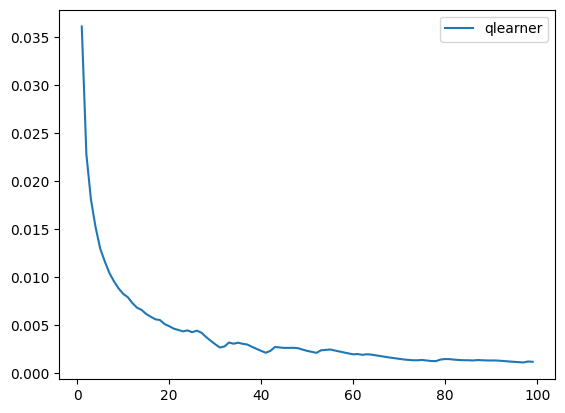

In [14]:
cv_df.plot()

In [15]:
timer.to_csv(pathlinker.prediction / "obp_duration.csv")

In [16]:
cv_df.iloc[range(0, 100, 10), :]

qlearner
0        NaN
10  0.008259
20  0.004886
30  0.003007
40  0.002312
50  0.002312
60  0.001952
70  0.001482
80  0.001465
90  0.001309

In [17]:
tg_flg = output_df["treatment"] == 1
output_df.loc[tg_flg, "conversion"].mean() - output_df.loc[~tg_flg, "conversion"].mean()

0.0011518730521316279